<table>
<td>
<img src="https://people.iee.ihu.gr/~kdiamant/images/kdiamantaras2.jpg" alt="Kostas Diamantaras" height="100"/>
</td>
<td>
<p>Konstantinos Diamantaras</p>
<p>Department of Information and Electronic Engineering</p>  
<p>International Hellenic University</p>  
<p>Greece</p>
</td>
<td>
<img src="https://people.iee.ihu.gr/~kdiamant/images/International_Hellenic_University_logo.jpg" alt="Kostas Diamantaras" height="100"/>
</td>
</table>

# Implement Embeddings and Recurrent models  
<ul>
<li> Use layers: <code>Embedding</code>, <code>LSTM</code>, <code>GRU</code>
<li> Build and train the model</li>
<li> Predict test patterns</li>
<li> Dataset: <a href="http://ai.stanford.edu/~amaas/data/sentiment/">IMDB Movie reviews</a></li>
</ul>

#### Load IMDB movie reviews dataset  
Dataset of 25000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indices (integers).

In [ ]:
from tensorflow.keras.datasets import imdb

num_words = 50000   # Vocabulary size = num_words. Use only the 50000 most frequent words
(xo_train, t_train), (xo_test, t_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=num_words)
print('Number of train documents {}'.format(xo_train.shape[0]))
print('Number of test documents {}'.format(xo_test.shape[0]))

Number of train documents 25000
Number of test documents 25000


Get `wordidx` dictionary: maps words --> indices  
Show the first 5 reviews

In [ ]:
wordidx = imdb.get_word_index()
for i in range(5):
    print('\nDocument #{} has {} words:'.format(i, len(xo_train[i])))
    for idx in xo_train[i][::-1]:
        print(list(wordidx.keys())[list(wordidx.values()).index(idx)],
                end=" ")
    print('\n{}'.format(xo_train[i][::-1]))


Document #0 has 218 words:
an want film heartfelt with for an watch acting armed with to wasn't with that most nobody her with their script of two have then bit one from when but barrel at real to heart he history while not you script of but frog thought is should he she boat an any 1 for mean of most two was odd 'n of br some half name he history themselves out than from whether to show's br gilmore's of anyone for landed over seen of in tricky other with itself as to very will one isn't that you is they critics have what why from when does have to serious her with that here of they shadows had heart with musicians 70s of to character in seeing in that wonderful story to pratfalls but scary with that movie sometimes movie you of camp was for get her themselves out with that him than you of unfortunately potentially mine of you as film current now is with more enough of several was her except movie visual chest every of or moments help villaronga going never every of years to shows he

Preprocess the data  
Use `pad_sequences()` to cut each sentence to `maxlen` length. If a sentence is shorter than `maxlen` it is padded with zeros.

In [ ]:
from tensorflow.keras.preprocessing import sequence

maxlen = 80
x_train = sequence.pad_sequences(xo_train, maxlen=maxlen)
x_test = sequence.pad_sequences(xo_test, maxlen=maxlen)
print('Training data shape = {}'.format(x_train.shape))
print('Test data shape = {}'.format(x_test.shape))
for i in range(5):
    print('Document #{}: {} words: {}'.format(i, len(x_train[i]), list(x_train[i])[::-1]))

Training data shape = (25000, 80)
Test data shape = (25000, 80)
Document #0: 80 words: [32, 178, 19, 5345, 16, 15, 32, 103, 113, 4472, 16, 5, 283, 16, 12, 88, 1334, 38, 16, 65, 226, 4, 104, 25, 92, 224, 28, 36, 51, 18, 5535, 30, 144, 5, 480, 26, 476, 134, 21, 22, 226, 4, 18, 7486, 194, 6, 141, 26, 56, 2071, 32, 98, 297, 15, 381, 4, 88, 104, 13, 1029, 12118, 4, 7, 46, 317, 400, 26, 476, 530, 43, 71, 36, 723, 5, 3766, 7, 31050, 4, 256, 15]
Document #1: 80 words: [95, 145, 16, 285, 78, 89, 33, 462, 154, 52, 6, 28, 5, 1355, 4, 16, 15, 1690, 4, 23, 145, 168, 8, 9, 1382, 64, 625, 22, 78, 371, 6, 9, 14, 1212, 7464, 32, 46151, 18, 491, 152, 131, 9837, 4, 5, 2350, 245, 656, 25249, 5, 8255, 228, 4373, 9, 50, 136, 175, 220, 11, 174, 120, 5, 120, 299, 15, 1157, 36893, 43, 9, 228, 4, 5, 98, 4362, 165, 349, 15, 6853, 23141, 68, 125]
Document #2: 80 words: [113, 129, 7, 227, 6, 534, 35, 624, 607, 106, 8, 9, 14, 2, 89, 638, 79, 191, 13, 1352, 595, 116, 595, 23, 170, 9, 51, 2307, 6, 47, 22, 4, 11, 31, 

In [ ]:
import tensorflow.keras.backend as K
try:
    K.clear_session()
    del model
except:
    print('No model to clear')

### Embedding layer (see [Embedding layers](https://keras.io/layers/embeddings/))  
*Embedding* is the concept of assigning a vector of dimension $m$ to some object for the purpose of inserting this vector into a machine learning algorithm. For example, in Natural Language Processing (NLP), words in the English dictionary are embedded into $m$-dimensional vectors with the purpose of classifying sentences according to content.
In this case $N$ is the size of the English vocabulary (typically in the order of millions) and $m$ is the embedding size chosen by the user (typically $m$=100, 200, 300, or something of that order of magnitude).  

Embeddings are implemented using an $N\times m$ matrix $\mathbf{E}$. The keras `Embedding` layer implements a *look-up* operation: the 2-d input tensor `x` contains integer indices pointing to the rows of $\mathbf{E}$.
For every element $x_{ij} == index$ of `x` we obtain the row $\mathbf{e}_{index}$ of $\mathbf{E}$ and insert it into the output tensor `y` in the position $i,j$.
If the input tensor `x` has size (B,L) then the output tensor `y` will have size (B,L,m), where B is the batch size.  

**Example**:  

<table><tr>
<td>
<pre><code>
E = [[0.5, 0. , 0.4, 0. ],
     [0. , 0.8, 0.2, 0.2],
     [0.7, 0.1, 0.5, 0.1],
     [0.3, 0.9, 0.8, 0.3],
     [0.8, 0.4, 0.7, 0.3],
     [0.9, 0.5, 0.1, 0.5],
     [0.7, 0.7, 0.5, 0.5],
     [0.7, 0.4, 0. , 0.2],
     [0.3, 0.5, 0.7, 0.9],
     [0.3, 0.8, 0.2, 0.8]]
</code></pre>
</td>
<td>
<pre><code>
x = [[1,3],
     [4,8],
     [0,9]]
</code></pre>
</td>
<td>
<pre><code>
y = [[[0. , 0.8, 0.2, 0.2],
      [0.3, 0.9, 0.8, 0.3]],
     [[0.8, 0.4, 0.7, 0.3],
      [0.3, 0.5, 0.7, 0.9]],
     [[0.5, 0. , 0.4, 0. ],
      [0.3, 0.8, 0.2, 0.8]]]
</code></pre>
</td>
</tr><table>

The embedding matrix `E` has size (10,4). Using the NLP paradigm, this means that our vocabulary has 10 words and each word is represented by a 4-dim vector. The input tensor `x` has size (3,2). Therefore, the output tensor `y` has size (3,2,4). Note that the elements of `x` are indices to the rows of `E`, therefore they must be integers. Moreover, these integers must be between 0 and the rows of `E` - 1 (ie. between 0 and 9 in this case). Using the NLP paradigm again, each row of `x` is a *phrase* containing the indices of exactly 2 words.  

The `Embedding()` constructor has two required arguments: `input_dim` = number of rows and `output_dim` = number of columns.

Embedding layers are trainable. The $\mathbf{E}$ matrix can be updated using a suitable learning rule.  

The `Embedding` layer can only be used as the first layer in a model.

In [ ]:
from tensorflow.keras.layers import Input, Embedding

embedding_size = 3    # Dimension of embedding vectors (number of columns in embedding matrix)
x_in = Input([maxlen])  # Each sentence in a batch contains maxlen words
emb = Embedding(num_words, embedding_size)(x_in)

#### LSTM layer (see [Recurrent Layers](https://keras.io/layers/recurrent/))  

The Long Short Term Memory model (LSTM) is one of the most popular recurrent networks.
Its output $\mathbf{y}(t)$ at time step $t$ is a function of the current input $\mathbf{x}(t)$ and the current cell state $\mathbf{c}(t)$ where, in turn, $\mathbf{c}(t)$ is a function of the previous cell state $\mathbf{c}(t-1)$ and previous output $\mathbf{y}(t-1)$. So, the current output depends not only on the current input but also on all the inputs before that (for ever before), i.e. it has potentially infinite memory.  

The model is described by the following recurrent equations ($\bullet$ denotes elementwise vector multiplication):

* Input: $\mathbf{x}(t)$  
* Output: $\mathbf{y}(t) = \mathbf{g}_{out}(t) \bullet \sigma_o(\mathbf{c}(t))$  
* Cell state: $\mathbf{c}(t) = \mathbf{g}_{in}(t)\bullet \mathbf{i}(t) + \mathbf{f}(t) \bullet \mathbf{c}(t-1)$  
* Cell state input: $\mathbf{i}(i) = \sigma_i(\mathbf{W}_i\mathbf{x}(t) + \mathbf{R}_i\mathbf{y}(t-1) + \mathbf{b}_i)$
* Forgetting gate: $\mathbf{f}(t) = \sigma(\mathbf{W}_f\mathbf{x}(t) + \mathbf{R}_f\mathbf{y}(t-1) + \mathbf{b}_f)$  
* Input gate: $\mathbf{g}_{in}(t) = \sigma(\mathbf{W}_{gi}\mathbf{x}(t) + \mathbf{R}_{gi}\mathbf{y}(t-1) + \mathbf{b}_{gi})$  
* Output gate: $\mathbf{g}_{out}(t) = \sigma(\mathbf{W}_{go}\mathbf{x}(t) + \mathbf{R}_{go}\mathbf{y}(t-1) + \mathbf{b}_{go})$  

$\mathbf{W}_\star$, $\mathbf{R}_\star$ are weight matrices and $\mathbf{b}_\star$ are bias vectors ($\star = i, f, gi, go$)..  
$\sigma()$ is the logistic sigmoid function  
$\sigma_i()$, $\sigma_o()$ is usually the $\tanh$ function.  

All recurrent models, including the LSTM, are suitable for Machine Learning problems where the target value depends on the *order* of the input sequence. For example, we make the assumption that the sentiment of a document depends on the order of the words in it:  

$sentiment = function(word(1),word(2),\dots,word(T))$

In [ ]:
from tensorflow.keras.layers import LSTM, Dropout

lstm_units = 5  # LSTM output is 5-dimensional
lstm = LSTM(units=lstm_units, dropout=0.5)(emb)

#### Build the model

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#xd = Dense(100, activation='relu')(lstm)
#xd = Dropout(0.8)(xd)
out = Dense(2, activation='softmax')(lstm)
model = Model(inputs=x_in, outputs=out)

lr = 1e-4   # Learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr),
              metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 3)             150000    
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 180       
_________________________________________________________________
dense (Dense)                (None, 2)                 12        
Total params: 150,192
Trainable params: 150,192
Non-trainable params: 0
_________________________________________________________________


#### Train the LSTM model

In [ ]:
max_epochs = 20
batch_size = 32
history = model.fit(x_train, t_train,
                    validation_data=(x_test,t_test),
                    epochs=max_epochs,
                    batch_size=batch_size)

Epoch 1/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6926 - acc: 0.5314 - val_loss: 0.6910 - val_acc: 0.5521
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6489 - acc: 0.6472 - val_loss: 0.5956 - val_acc: 0.7252
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.5792 - acc: 0.7255 - val_loss: 0.5444 - val_acc: 0.7558
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 0.5263 - acc: 0.7648 - val_loss: 0.5058 - val_acc: 0.7754
Epoch 5/20
782/782 [==============================] - 9s 11ms/step - loss: 0.4786 - acc: 0.7939 - val_loss: 0.4760 - val_acc: 0.7864
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4407 - acc: 0.8125 - val_loss: 0.4468 - val_acc: 0.8006
Epoch 7/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4067 - acc: 0.8286 - val_loss: 0.4243 - val_acc: 0.8079
Epoch 8/20
782/782 [==============================] - 8s 11ms/step - 

#### Plot LSTM training, testing performance

Text(0.5, 0, 'Epochs')

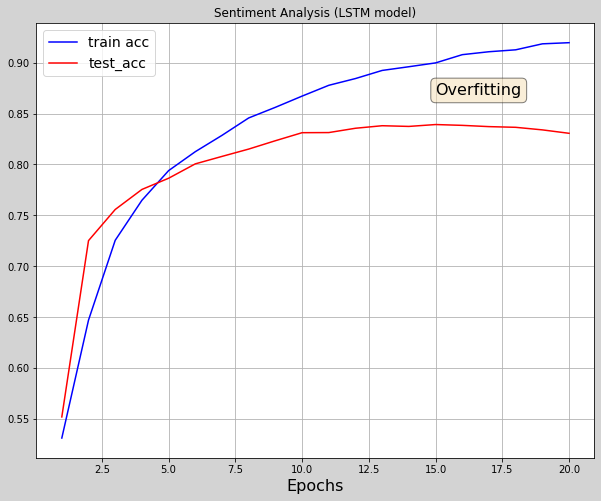

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('lightgray')
plt.plot(np.arange(1,max_epochs+1),history.history['acc'], 'b')
plt.plot(np.arange(1,max_epochs+1),history.history['val_acc'], 'r')
plt.legend(['train acc', 'test_acc'], fontsize=14)
ax.text(15, 0.88, 'Overfitting', fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.grid(b=True)
plt.title('Sentiment Analysis (LSTM model)')
plt.xlabel('Epochs', fontsize=16)

## GRU  
#### Build the same model using the GRU layer (see [Recurrent Layers](https://keras.io/api/layers/recurrent_layers/gru/))

In [ ]:
from tensorflow.keras.layers import GRU
def gru_model(gru_units = 5):
    embedding_size = 3    # Embedding vector dimension
    x_in = Input([maxlen])
    emb = Embedding(num_words, embedding_size)(x_in)
    gru = GRU(units=lstm_units, dropout=0.5)(emb)
    out = Dense(2, activation='softmax')(gru)
    model = Model(inputs=x_in, outputs=out)
    return model

model2 = gru_model()
lr = 1e-4   # Learning rate
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=lr),
              metrics=['acc'])

model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 3)             150000    
_________________________________________________________________
gru (GRU)                    (None, 5)                 150       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12        
Total params: 150,162
Trainable params: 150,162
Non-trainable params: 0
_________________________________________________________________


#### Train the GRU model

In [ ]:
max_epochs = 20
batch_size = 32
history2 = model2.fit(x_train, t_train,
                    validation_data=(x_test,t_test),
                    epochs=max_epochs,
                    batch_size=batch_size)

Epoch 1/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6926 - acc: 0.5156 - val_loss: 0.6918 - val_acc: 0.5449
Epoch 2/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6901 - acc: 0.5631 - val_loss: 0.6884 - val_acc: 0.6126
Epoch 3/20
782/782 [==============================] - 8s 10ms/step - loss: 0.6825 - acc: 0.6165 - val_loss: 0.6749 - val_acc: 0.6555
Epoch 4/20
782/782 [==============================] - 8s 10ms/step - loss: 0.5925 - acc: 0.6994 - val_loss: 0.4932 - val_acc: 0.7691
Epoch 5/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4761 - acc: 0.7758 - val_loss: 0.4386 - val_acc: 0.8045
Epoch 6/20
782/782 [==============================] - 8s 10ms/step - loss: 0.4285 - acc: 0.8071 - val_loss: 0.4104 - val_acc: 0.8136
Epoch 7/20
782/782 [==============================] - 8s 10ms/step - loss: 0.3965 - acc: 0.8257 - val_loss: 0.3931 - val_acc: 0.8217
Epoch 8/20
782/782 [==============================] - 8s 10ms/step - 

#### Plot GRU training, testing performance

Text(0.5, 0, 'Epochs')

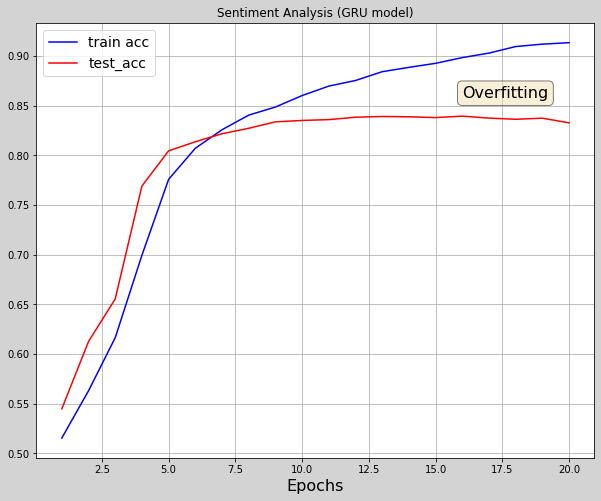

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
fig.set_facecolor('lightgray')
plt.plot(np.arange(1,max_epochs+1),history2.history['acc'], 'b')
plt.plot(np.arange(1,max_epochs+1),history2.history['val_acc'], 'r')
plt.legend(['train acc', 'test_acc'], fontsize=14)
ax.text(16, 0.87, 'Overfitting', fontsize=16,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.grid(b=True)
plt.title('Sentiment Analysis (GRU model)')
plt.xlabel('Epochs', fontsize=16)

### Compare performances: LSTM vs. GRU

In [ ]:
print('Performance comparison after {} epochs:'.format(max_epochs))
print('LSTM :\tTrain Accuracy ={:8.5f}\t Test Accuracy ={:8.5f}'.format(history.history['acc'][max_epochs-1], history.history['val_acc'][max_epochs-1]))
print('GRU :\tTrain Accuracy ={:8.5f}\t Test Accuracy ={:8.5f}'.format(history2.history['acc'][max_epochs-1], history2.history['val_acc'][max_epochs-1]))

Performance comparison after 20 epochs:
LSTM :	Train Accuracy = 0.91952	 Test Accuracy = 0.83056
GRU :	Train Accuracy = 0.91332	 Test Accuracy = 0.83268
